## Analysing loading factors for sales price of property

In [1]:
# import libraries and run a few checks
import sys
assert sys.version_info >= (3, 5)
import operator 

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

import seaborn as sns
sns.set(palette='Paired', style='white')

import warnings 
warnings.filterwarnings('ignore')

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

# utility function to save figures for presentation
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
original_df = pd.read_csv(r'original_data.csv')

## Packages

In [4]:
# preprocessor and pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [14]:
# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

# evaluations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

# model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [6]:
# adding cat_cols back to transformed data
cat_cols = ['zip_code', 'residential_type']
num_cols = ['floor_area','lot_area','cost_total_pre', 'cost_pre', 'cost_eq_pre', 'duration', 'sales_price_begin', 'n_permits', 'BSI', 'WPI', 'floor_area_permit', 'liquidity', 'private_invest', 'LPI', 'n_loans_extend', 'amount_loans_extend', 'interest_rate', 'avg_cost_private_start', 'avg_cost_private_end', 'exchange_rate', 'street_exchange_rate', 'CPI', 'CPI_housing', 'stock_market_index', 'population', 'gold_price', 'avg_loans', 'street_to_official_ex', 'CPI_housing_proportion']
num_cols_cut = [x for x in num_cols if x not in ['n_permits','LPI','n_loans_extend']]
num_cols_cut2 = [x for x in num_cols if x not in ['n_permits','LPI','n_loans_extend','street_exchange_rate','exchange_rate','amount_loans_extend', 'WPI']]

## Explainable model : linear regression

### Linear regression for all variables

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt


def scaled_rmse(y_true, y_pred):
    """
    Rescaled RMSE
    
    Parameters
        
        y_true: vector of labels
        y_pred: vector of predictions
    """
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse / np.mean(y_true**2))


def score_model(model, data, metric):
    """
    Score model on data according to metric
    
    Parameters
        
        model: sklearn model instance
        data: tuple of inputs and labels
        metric: callable metric function metric(y_true, y_pred)
    """
    x, y_true = data
    y_pred = model.predict(x)
    return metric.__name__, metric(y_true, y_pred)


def train_and_evaluate(model,
                       train_data,
                       test_data,
                       X_data,
                       y_data,
                       featurelist,
                       cols,
                       metrics=[r2_score, mean_squared_error, scaled_rmse, mean_absolute_error],
                       cv = 5,
                       tree = False,
                       agnostic = False,
                       PCA_true = False,
                       PCA_ncomponents = 26):
    """
    Evaluates the train/test performance of model
    
    Parameters
        
        model: sklearn model instance
        train_data: tuple of training inputs and labels
        test_data: tuple of testing inputs and labels
        metrics: a list of callable metrics to evaluate
    """

    # Train model

    if cv > 1:
        kf = KFold(n_splits=cv, random_state=None, shuffle=False)
    
        #print(f'{"="*100} \n Evaluating: \n {model} \n{"="*100}')
        r2list = []
        mselist = []
        rmselist = []
        maelist = []
        
        #Pre processing
        for train_index, test_index in kf.split(X_data):
            
            X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
            y_train, y_test = np.array(y_data)[train_index], np.array(y_data)[test_index]
            
            if PCA_true: 
                pipe = make_pipeline(StandardScaler(), PCA(n_components = PCA_ncomponents))
                preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                                    ('num', pipe, cols)])
            else:
                preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), cols)])
                
            X_train = preprocessor.fit_transform(X_train)
            X_test = preprocessor.transform(X_test)

            model.fit(X_train, y_train)
        
            #print(f'{"="*100} \n Evaluating: \n {model} \n{"="*100}')
            for m in metrics:
                m_name, m_value_train = score_model(model=model,
                                                    data=(X_train, y_train),
                                                    metric=m)
                _, m_value_test = score_model(model=model, data=(X_test, y_test), metric=m)
                #print(
                #    f'{m_name:<20} {m_value_train:>10.3f} (train) {m_value_test:>10.3f} (test)'
                #)
                if m_name == 'r2_score':
                    r2list.append(m_value_test)
                if m_name == 'mean_squared_error':
                    mselist.append(m_value_test)
                if m_name == 'scaled_rmse':
                    rmselist.append(m_value_test)
                if m_name == 'mean_absolute_error':
                    maelist.append(m_value_test)
                    
        print("Kfold CV results")
        print(f'{"="*100} \n Evaluating: \n {model} \n{"="*100}')      
        print("{:<20}: {:>10.3f}\n{:<20}: {:>10.3f}\n{:<20}: {:>10.3f}\n{:<20}: {:>10.3f}".format("r2_score:",sum(r2list)/len(r2list),
                                                                "mean_squared_error:",sum(mselist)/len(mselist),
                                                                "scaled_rmse:",sum(rmselist)/len(rmselist),
                                                                "mean_absolute_error:",sum(maelist)/len(maelist),))
        
        return sum(r2list)/len(r2list),sum(mselist)/len(mselist),sum(rmselist)/len(rmselist),sum(maelist)/len(maelist)
    
    
    if cv == 1:
        model.fit(*train_data)
        # Evaluate Model
        print(f'{"="*100}')
        print("Test results")
        print(f'{"="*100} \n Evaluating: \n {model} \n{"="*100}')
        for m in metrics:
            m_name, m_value_train = score_model(model=model,
                                                data=train_data,
                                                metric=m)
            _, m_value_test = score_model(model=model, data=test_data, metric=m)
            print(
                f'{m_name:<20} {m_value_train:>10.3f} (train) {m_value_test:>10.3f} (test)'
            )

        # Plot data
        fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        sns.scatterplot(
            x=train_data[1],
            y=model.predict(train_data[0]),
            ax=ax[0],
            alpha=0.5,
        )
        ax[0].set_title('Train')
        sns.scatterplot(
            x=test_data[1],
            y=model.predict(test_data[0]),
            ax=ax[1],
            alpha=0.5,
        )
        ax[1].set_title('Test')

        for a in ax:
            a.set_xlabel('y_true')
            a.set_ylabel('y_pred')
            a.plot(a.get_xlim(), a.get_ylim(), ls='--', c='k')
        
        if not agnostic:
            if tree:
                item1 = model.feature_importances_
            else:
                item1 = model.coef_
            return model, list(zip(featurelist,item1))
    
    

In [8]:
#Pre processing
X_train, X_test, y_train, y_test = train_test_split(original_df[cat_cols + num_cols], original_df['sales_price'], test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

In [9]:
featurelist = list(preprocessor.get_feature_names_out(X_train.columns))

In [10]:
#Modelling

linear_regressor = LinearRegression()
r2, mse, scaled_rmse, mae =  train_and_evaluate(
    model=linear_regressor,
    train_data="NA",
    test_data="NA",
    X_data = X_train,                          #for kfoldcv
    y_data = y_train,                          #for kfoldcv
    cols = num_cols,
    featurelist = "NA",
    cv = 10,
)

Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.972
mean_squared_error: :  39613.463
scaled_rmse:        :      0.104
mean_absolute_error::    106.937


Test results
 Evaluating: 
 LinearRegression() 
r2_score                  0.985 (train)      0.983 (test)
mean_squared_error    20419.247 (train)  30571.945 (test)
scaled_rmse               0.081 (train)      0.083 (test)
mean_absolute_error      83.526 (train)    117.390 (test)


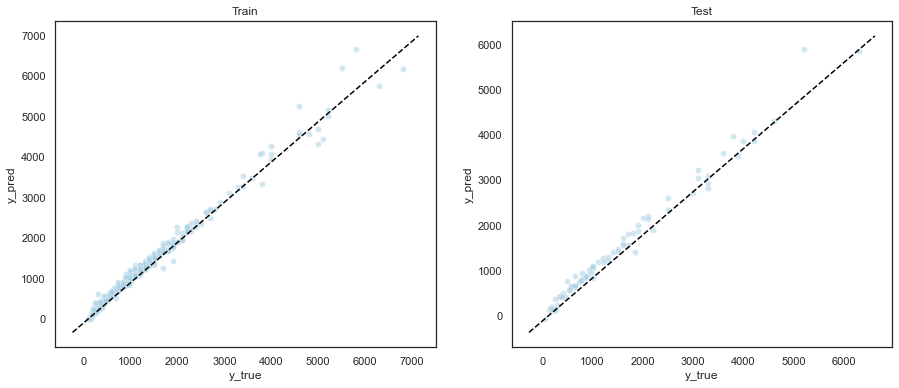

In [11]:
# test, set cv = 1 for test

linear_regressor = LinearRegression()
model, result = train_and_evaluate(
    model=linear_regressor,
    train_data=(X_train_prepared, y_train),
    test_data=(X_test_prepared, y_test),
    X_data = "NA",                          #for kfoldcv
    y_data = "NA",                          #for kfoldcv
    cols = num_cols,
    featurelist = featurelist,
    cv = 1,
)

### LM for only statistically significant variables

In [12]:
#Pre processing
X_train, X_test, y_train, y_test = train_test_split(original_df[cat_cols + num_cols_cut2], original_df['sales_price'], test_size=0.2, random_state=42)


In [13]:
#Modelling
linear_regressor = LinearRegression()
train_and_evaluate(
    model=linear_regressor,
    train_data="NA",  
    test_data="NA",
    X_data = X_train,                #for kfoldcv, split before scaling   
    y_data = y_train,               #for kfoldcv, split before scaling
    cols = num_cols_cut2,
    featurelist = "NA",
    cv = 10
)

Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.974
mean_squared_error: :  37090.157
scaled_rmse:        :      0.101
mean_absolute_error::    102.034


(0.9736021711153393,
 37090.15676654343,
 0.10125401320034837,
 102.03412914439666)

Test results
 Evaluating: 
 LinearRegression() 
r2_score                  0.985 (train)      0.984 (test)
mean_squared_error    20622.652 (train)  30293.964 (test)
scaled_rmse               0.081 (train)      0.083 (test)
mean_absolute_error      83.141 (train)    116.858 (test)


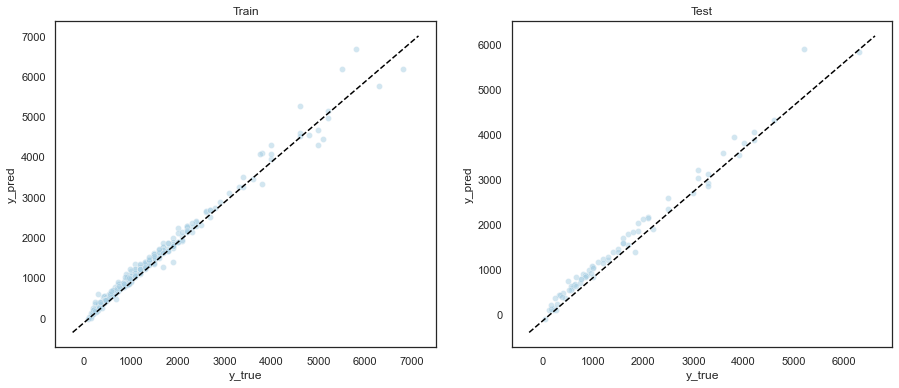

In [14]:
#preprocessing
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), num_cols_cut2)])
X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

featurelist = list(preprocessor.get_feature_names_out(X_train.columns))

#test
linear_regressor = LinearRegression()
model, result = train_and_evaluate(
    model=linear_regressor,
    train_data=(X_train_prepared, y_train),  
    test_data=(X_test_prepared, y_test),
    X_data = "NA",                #for kfoldcv, split before scaling
    y_data = "NA",               #for kfoldcv, split before scaling
    cols = "NA",
    featurelist = featurelist,
    cv = 1
)

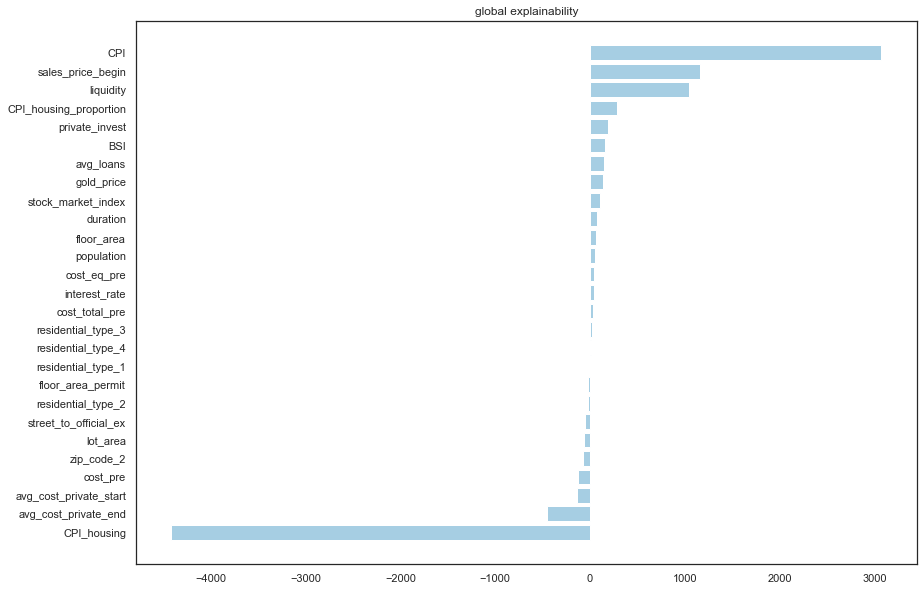

In [15]:
#Global explainability from linear regression

sorted_labels = sorted(result, key=lambda x: x[1])

#plotting the list
plt.subplots(figsize=(14, 10))
labels, values = zip(*(sorted_labels))
plt.barh(range(len(labels)),values)
plt.yticks(range(len(values)),[x[5:] for x in labels])
plt.title("global explainability")
plt.show()

In [16]:
X_all = preprocessor.transform(original_df[cat_cols + num_cols_cut2])

firstrowdata = dict(zip(featurelist, X_all[0]))
result_dict = dict(result)

In [17]:
ind_dict = {}
for k,v in result_dict.items():
    ind_dict[k] = firstrowdata[k]*result_dict[k]

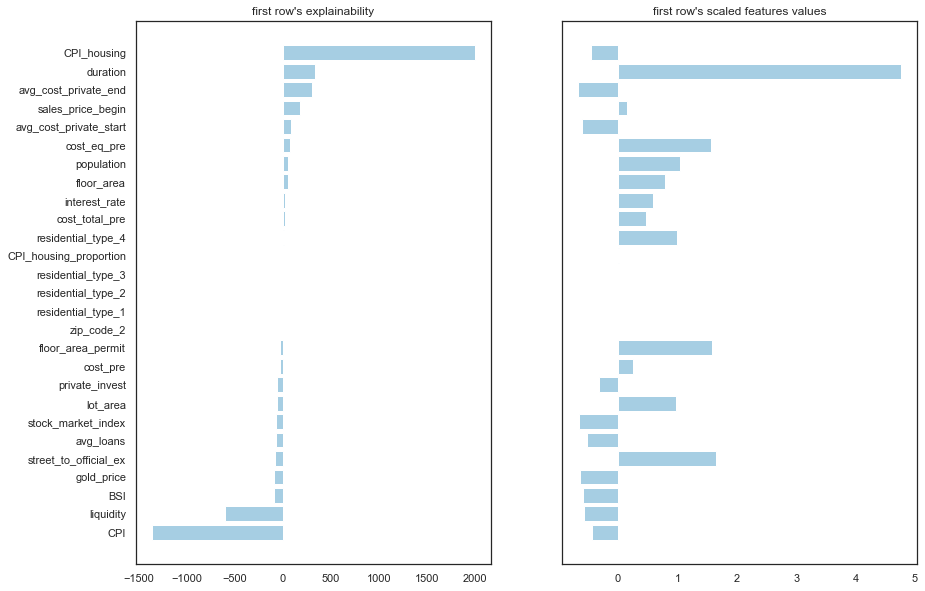

In [18]:
#individual explainability from linear regression

sorted_labels = sorted(ind_dict.items(), key = lambda x:x[1])

#plotting the list
plt.figure(figsize=(14, 10))
plt.subplot(121)
labels, values = zip(*(sorted_labels))
plt.barh(range(len(labels)),values)
plt.yticks(range(len(values)),[x[5:] for x in labels])
plt.title("first row's explainability")

dict_sort = dict(sorted_labels)
merged_dict = {}
for k,v in dict_sort.items():
    merged_dict[k] =  firstrowdata[k]
    
plt.subplot(122)
labels1, values1 = list(merged_dict.keys()), list(merged_dict.values())
plt.barh(range(len(labels1)),values1)
plt.yticks(range(len(labels1)),[])
plt.title("first row's scaled features values")
plt.show()    

### Linear regression for all extracted features from PCA

In [19]:
#Pre processing
from sklearn.decomposition import PCA

cols = num_cols_cut2

X_train, X_test, y_train, y_test = train_test_split(original_df[cat_cols + cols], original_df['sales_price'], test_size=0.2, random_state=42)


In [20]:
len(num_cols_cut2)

22

In [21]:
#Modelling
linear_regressor = LinearRegression()

r2l = []
msel = []
srmse = []
mael= []
nl = []

for n in range (1,len(num_cols_cut2)+1):
    
    r2, mse, scaled_rmse, mae = train_and_evaluate(
        model=linear_regressor,
        train_data="NA",
        test_data="NA",
        X_data = X_train,                 #for PCA kfoldcv
        y_data = y_train,                 #for PCA kfoldcv
        cols = cols,
        featurelist = "NA",
        cv = 10,
        PCA_true = True,
        PCA_ncomponents = n,
        )
    nl.append(n)
    r2l.append(r2)
    msel.append(mse)
    srmse.append(scaled_rmse)
    mael.append(mae)
    
    print("PCA components: {}".format(n))
    
result_df = pd.DataFrame(
    {'n_components': nl,
     'R2_score': r2l,
     'mean_squared_error': msel,
     'scaled_RMSE': srmse,
     'mean_absolute_error':mael
    })

Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.606
mean_squared_error: : 494687.681
scaled_rmse:        :      0.396
mean_absolute_error::    478.813
PCA components: 1
Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.625
mean_squared_error: : 477670.191
scaled_rmse:        :      0.385
mean_absolute_error::    462.683
PCA components: 2
Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.628
mean_squared_error: : 469088.400
scaled_rmse:        :      0.384
mean_absolute_error::    460.056
PCA components: 3
Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.626
mean_squared_error: : 476527.281
scaled_rmse:        :      0.382
mean_absolute_error::    437.766
PCA components: 4
Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.640
mean_squared_error: : 458125.761
scaled_rmse:        :      0.374
mean_absolute_error::    424.998
PCA comp

Kfold CV results
 Evaluating: 
 LinearRegression() 
r2_score:           :      0.974
mean_squared_error: :  37090.157
scaled_rmse:        :      0.101
mean_absolute_error::    102.034
PCA components: 22


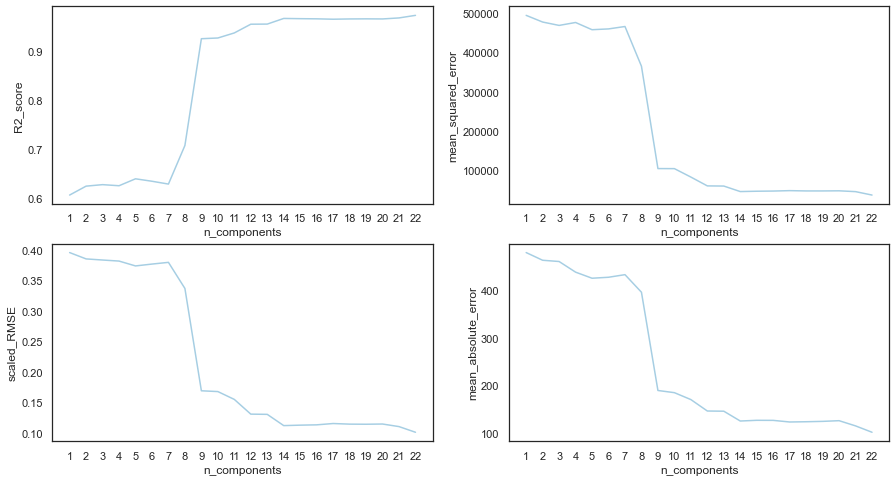

In [22]:
plt.figure(figsize=(15, 8))
plt.subplot(221)
sns.lineplot(data=result_df, x="n_components", y="R2_score")
plt.xticks(np.arange(1, 23, 1.0))
plt.subplot(222)
sns.lineplot(data=result_df, x="n_components", y="mean_squared_error")
plt.xticks(np.arange(1, 23, 1.0))
plt.subplot(223)
sns.lineplot(data=result_df, x="n_components", y="scaled_RMSE")
plt.xticks(np.arange(1, 23, 1.0))
plt.subplot(224)
sns.lineplot(data=result_df, x="n_components", y="mean_absolute_error")
plt.xticks(np.arange(1, 23, 1.0))
plt.show()

Test results
 Evaluating: 
 LinearRegression() 
r2_score                  0.976 (train)      0.973 (test)
mean_squared_error    31712.053 (train)  48972.314 (test)
scaled_rmse               0.101 (train)      0.106 (test)
mean_absolute_error     110.075 (train)    163.723 (test)


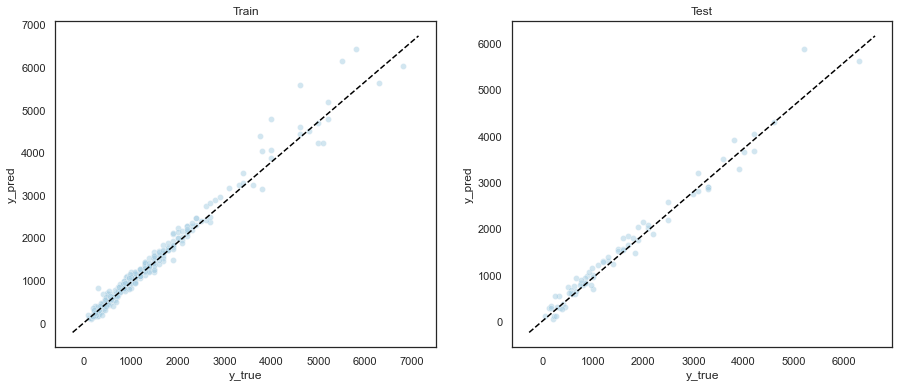

In [23]:
# Test - best result is PCA with 14 components

#Pre processing
pipe = make_pipeline(StandardScaler(), PCA(n_components = 14))

preprocessor_PC = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                    ('num', pipe, cols)])
X_train_prepared = preprocessor_PC.fit_transform(X_train)
X_test_prepared = preprocessor_PC.transform(X_test)

num_cols_all = ["num__pca0",
"num__pca1",
"num__pca2",
"num__pca3",
"num__pca4",
"num__pca5",
"num__pca6",
"num__pca7",
"num__pca8",
"num__pca9",
"num__pca10",
"num__pca11",
"num__pca12",
"num__pca13",
]


featurelist = list(preprocessor_PC.get_feature_names_out(X_train.columns))

#test
model, result = train_and_evaluate(
    model=linear_regressor,
    train_data=(X_train_prepared, y_train),
    test_data=(X_test_prepared, y_test),
    X_data = "NA",                 #for PCA kfoldcv
    y_data = "NA",                 #for PCA kfoldcv
    cols = "NA",
    featurelist = featurelist,
    cv = 1,
    )


In [24]:
pca = PCA(n_components = 14)
pca.fit_transform(X_train[cols])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=num_cols_all, index=cols)
loadings_df['features'] = cols

In [25]:
result_dict = dict(result)
feature_impt = {}
for index, row in loadings_df.iterrows():
    feat = row['features']
    tot_impt = 0
    for col in num_cols_all:
        f_impt = row[col]*result_dict[col] #variable loading *linear reg coef
        tot_impt += f_impt
    feature_impt[feat] = tot_impt/row[num_cols_all].to_numpy().sum()
   

In [26]:
for k,v in result_dict.items():
    if 'pca' not in k:
        feature_impt[k[5:]] = v

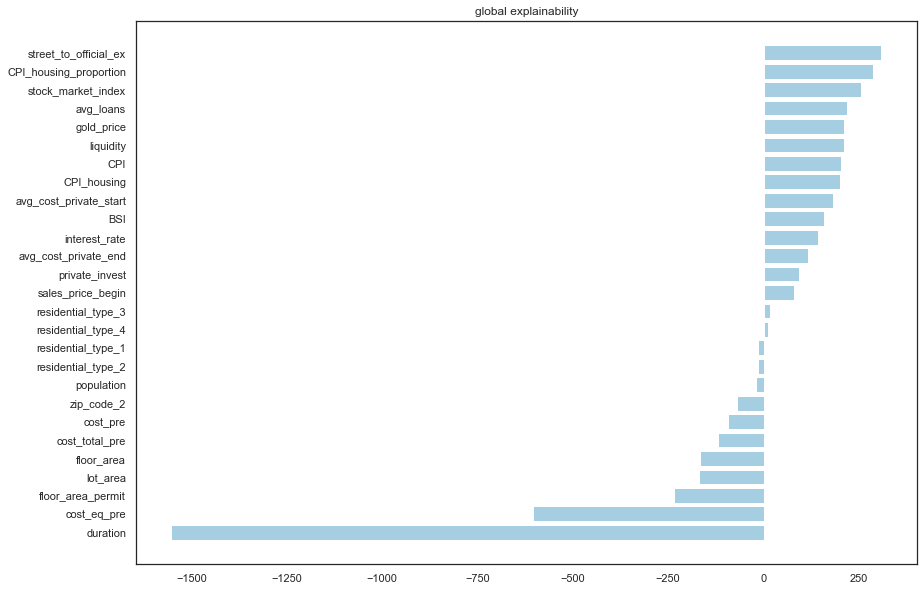

In [27]:
#global explainability from PCA extracted features

sorted_labels = sorted(feature_impt.items(), key = lambda x:x[1])


#plotting the list

plt.subplots(figsize=(14, 10))
labels, values = zip(*(sorted_labels))
plt.barh(range(len(labels)),values)
plt.yticks(range(len(values)),labels)
plt.title("global explainability")

plt.show()

In [55]:
#get scaled row data as used in PCA
X_train, X_test, y_train, y_test = train_test_split(original_df[cat_cols + cols], original_df['sales_price'], test_size=0.2, random_state=42)
preprocessor = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                  ('num', StandardScaler(), cols)])
preprocessor.fit_transform(X_train)

X_all = preprocessor.transform(original_df[cat_cols + cols])

featurelist = list(preprocessor.get_feature_names_out(X_train.columns))

# get first row's features values
firstrowdata = dict(zip((x[5:] for x in featurelist), X_all[15]))

In [57]:
feature_impt2 = {}
for index, row in loadings_df.iterrows():
    feat = row['features']
    tot_impt = 0
    for col in num_cols_all:
        f_impt = row[col]*result_dict[col]  #variable contribution * linear reg coef
        tot_impt += f_impt
    feature_impt2[feat] = tot_impt/row[num_cols_all].to_numpy().sum()*firstrowdata[feat] # feat importance * row's feat value

In [58]:
sum(feature_impt2.values())

2393.9059641137605

In [44]:
y_train.mean()

1333.939393939394

In [59]:
original_df['sales_price'][15]

3800

In [60]:
y = model.predict(X_test_prepared[2].reshape(1, -1))

In [61]:
y

array([3933.51979159])

In [62]:
for k,v in result_dict.items():
    if 'pca' not in k:
        feature_impt2[k[5:]] = v*firstrowdata[k[5:]]

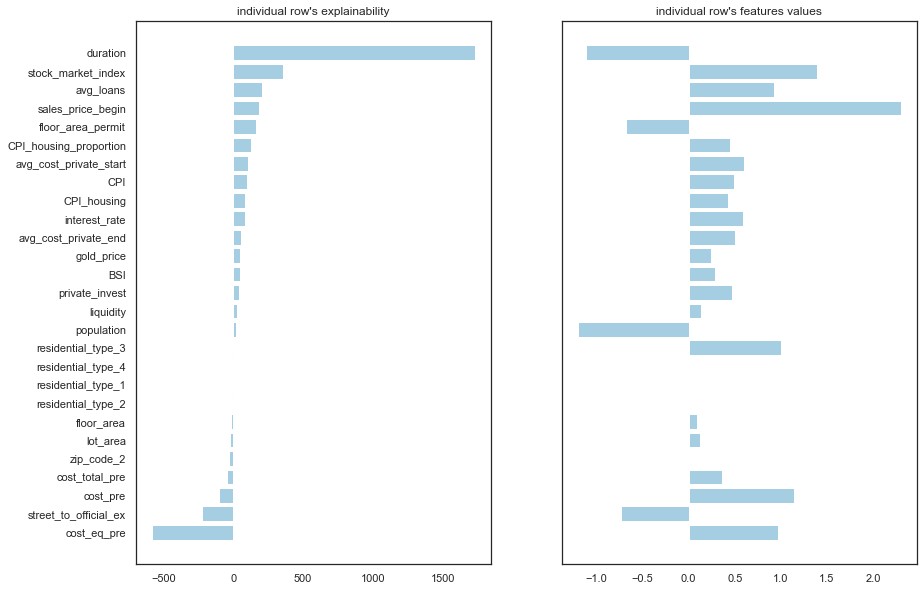

In [63]:
#individual explainability from PCA extracted features, for first row

sorted_labels = sorted(feature_impt2.items(), key = lambda x:x[1])

#plotting the list
plt.figure(figsize=(14, 10))
plt.subplot(121)
labels, values = zip(*(sorted_labels))
plt.barh(range(len(labels)),values)
plt.yticks(range(len(labels)),labels)
plt.title("individual row's explainability")

dict_sort = dict(sorted_labels)
merged_dict = {}
for k,v in dict_sort.items():
    merged_dict[k] =  firstrowdata[k]
    
plt.subplot(122)
labels1, values1 = list(merged_dict.keys()), list(merged_dict.values())
plt.barh(range(len(labels1)),values1)
plt.yticks(range(len(labels1)),[])
plt.title("individual row's features values")
plt.show()    

### SVM

In [15]:
cols = num_cols_cut2

X_train, X_test, y_train, y_test = train_test_split(original_df[cat_cols + cols], original_df['sales_price'], test_size=0.2, random_state=42)

pipe = make_pipeline(StandardScaler(), PCA(n_components = 14))

preprocessor_PC = ColumnTransformer([('cat', OneHotEncoder(drop='if_binary'), cat_cols),
                                    ('num', pipe, cols)])
X_train_prepared = preprocessor_PC.fit_transform(X_train)
X_test_prepared = preprocessor_PC.transform(X_test)

num_cols_all = ["num__pca0",
"num__pca1",
"num__pca2",
"num__pca3",
"num__pca4",
"num__pca5",
"num__pca6",
"num__pca7",
"num__pca8",
"num__pca9",
"num__pca10",
"num__pca11",
"num__pca12",
"num__pca13",
]

featurelist = list(preprocessor_PC.get_feature_names_out(X_train.columns))

In [16]:
from sklearn import metrics as met


def custom_loss_func(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return sqrt(mse / np.mean(y_true**2))


custom_scorer = met.make_scorer(custom_loss_func, greater_is_better=False)

In [17]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

param_grid = {'kernel': ['rbf', 'linear', 'poly'],
              'gamma': [0.1, 'scale'],
              'C': [1]}

svm_gs = GridSearchCV(
    estimator=SVR(),
    param_grid=param_grid, 
    scoring=custom_scorer, 
    cv=10,
    verbose=1)

svm_gs.fit(X_train_prepared, y_train)

print(svm_gs.best_params_)
print(svm_gs.best_score_)

params = {}
params['kernel'] = svm_gs.best_params_['kernel']
params['gamma'] = svm_gs.best_params_['gamma']

final_mdl = SVR(**params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
-0.4419403710920876


Test results
 Evaluating: 
 SVR(gamma=0.1, kernel='linear') 
r2_score                  0.551 (train)      0.486 (test)
mean_squared_error   601013.247 (train) 943060.954 (test)
scaled_rmse               0.439 (train)      0.463 (test)
mean_absolute_error     437.483 (train)    598.072 (test)


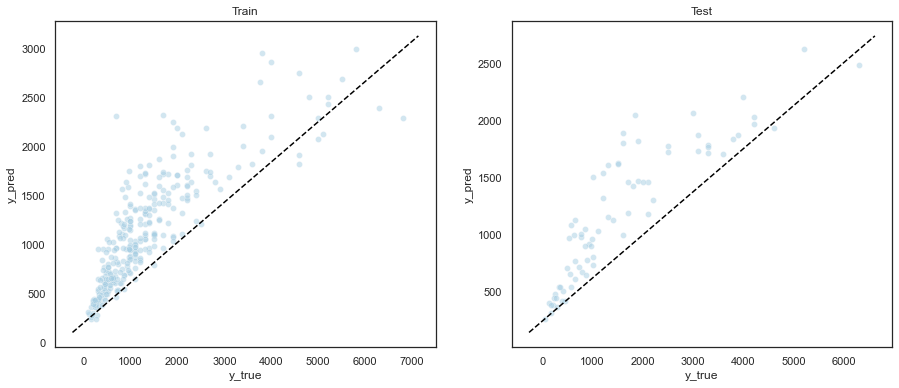

In [20]:
#test
model = train_and_evaluate(
    model=final_mdl,
    train_data=(X_train_prepared, y_train),
    test_data=(X_test_prepared, y_test),
    X_data = "NA",                 #for PCA kfoldcv
    y_data = "NA",                 #for PCA kfoldcv
    cols = "NA",
    featurelist = featurelist,
    agnostic = True,
    cv = 1,
    )

### Kernel ridge - linear

In [21]:
from sklearn.kernel_ridge import KernelRidge

param_grid = {'alpha': [0.1,0.2,0.3,0.5,0.7,0.9]}

krr_gs = GridSearchCV(
    estimator=KernelRidge(kernel='linear'),
    param_grid=param_grid, 
    scoring=custom_scorer, 
    cv=10,
    verbose=1)

krr_gs.fit(X_train_prepared, y_train)
           
print(krr_gs.best_params_)
print(krr_gs.best_score_)
           
params = {}
params['alpha'] = krr_gs.best_params_['alpha']

final_mdl = KernelRidge(**params)

Fitting 10 folds for each of 6 candidates, totalling 60 fits
{'alpha': 0.2}
-0.11192945491032076


Test results
 Evaluating: 
 KernelRidge(alpha=0.2) 
r2_score                  0.976 (train)      0.973 (test)
mean_squared_error    31757.413 (train)  49131.338 (test)
scaled_rmse               0.101 (train)      0.106 (test)
mean_absolute_error     109.400 (train)    162.994 (test)


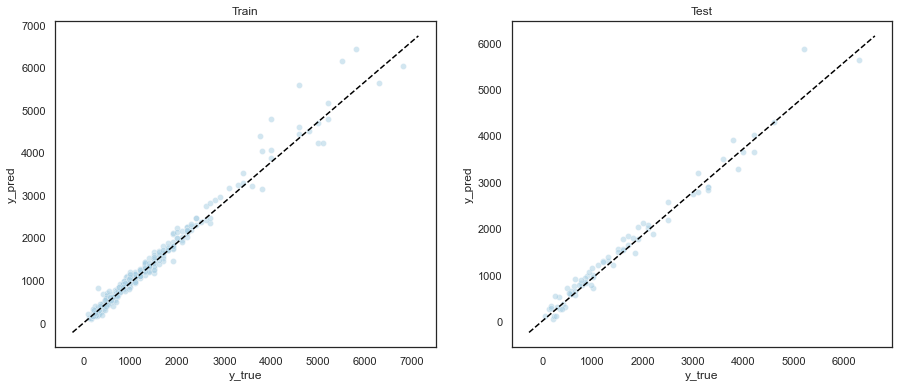

In [22]:
#test
model = train_and_evaluate(
    model=final_mdl,
    train_data=(X_train_prepared, y_train),
    test_data=(X_test_prepared, y_test),
    X_data = "NA",                 #for PCA kfoldcv
    y_data = "NA",                 #for PCA kfoldcv
    cols = "NA",
    featurelist = featurelist,
    agnostic = True,
    cv = 1,
    )

### Kernel ridge - Polynomial

In [23]:
from sklearn.kernel_ridge import KernelRidge

param_grid = {'alpha': [0.1,0.2,0.3,0.5,0.7,0.9],
             'degree': [2,3,4,5,6]}

krr_gs = GridSearchCV(
    estimator=KernelRidge(kernel='polynomial'),
    param_grid=param_grid, 
    scoring=custom_scorer, 
    cv=10,
    verbose=1)

krr_gs.fit(X_train_prepared, y_train)
           
print(krr_gs.best_params_)
print(krr_gs.best_score_)
           
params = {}
params['alpha'] = krr_gs.best_params_['alpha']
params['degree'] = krr_gs.best_params_['degree']

final_mdl = KernelRidge(**params)

Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'alpha': 0.1, 'degree': 2}
-0.07735886134687137


Test results
 Evaluating: 
 KernelRidge(alpha=0.1, degree=2) 
r2_score                  0.976 (train)      0.973 (test)
mean_squared_error    31723.546 (train)  49034.380 (test)
scaled_rmse               0.101 (train)      0.106 (test)
mean_absolute_error     109.677 (train)    163.355 (test)


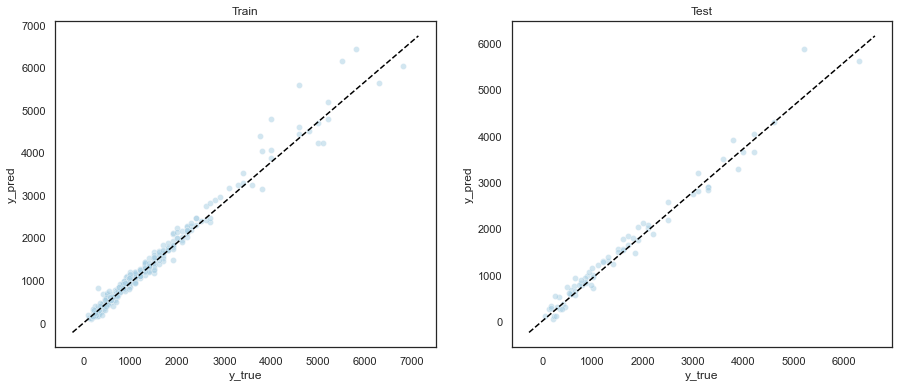

In [24]:
#test
model = train_and_evaluate(
    model =final_mdl,
    train_data=(X_train_prepared, y_train),
    test_data=(X_test_prepared, y_test),
    X_data = "NA",                 #for PCA kfoldcv
    y_data = "NA",                 #for PCA kfoldcv
    cols = "NA",
    featurelist = featurelist,
    agnostic = True,
    cv = 1,
    )

### Kernel ridge - RBF

In [25]:
from sklearn.kernel_ridge import KernelRidge

param_grid = {'alpha': [0.1,0.2,0.3,0.5,0.7,0.9],
             'gamma': [0.01,0.03, 0.05, 0.07, 0.09, 0.1, 0.5]}

krr_gs = GridSearchCV(
    estimator=KernelRidge(kernel='rbf'),
    param_grid=param_grid, 
    scoring=custom_scorer, 
    cv=10,
    verbose=1)

krr_gs.fit(X_train_prepared, y_train)
           
print(krr_gs.best_params_)
print(krr_gs.best_score_)
           
params = {}
params['alpha'] = krr_gs.best_params_['alpha']
params['gamma'] = krr_gs.best_params_['gamma']

final_mdl = KernelRidge(**params)

Fitting 10 folds for each of 42 candidates, totalling 420 fits
{'alpha': 0.1, 'gamma': 0.01}
-0.11820208484848067


Test results
 Evaluating: 
 KernelRidge(alpha=0.1, gamma=0.01) 
r2_score                  0.976 (train)      0.973 (test)
mean_squared_error    31723.546 (train)  49034.380 (test)
scaled_rmse               0.101 (train)      0.106 (test)
mean_absolute_error     109.677 (train)    163.355 (test)


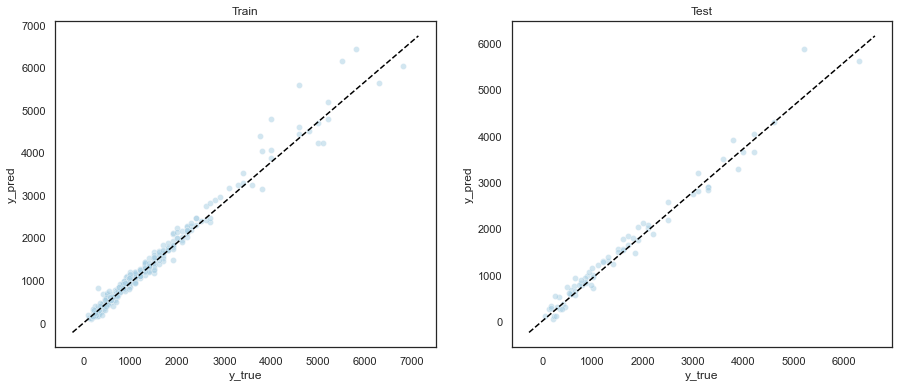

In [26]:
#test
model = train_and_evaluate(
    model=final_mdl,
    train_data=(X_train_prepared, y_train),
    test_data=(X_test_prepared, y_test),
    X_data = "NA",                 #for PCA kfoldcv
    y_data = "NA",                 #for PCA kfoldcv
    cols = "NA",
    featurelist = featurelist,
    agnostic = True,
    cv = 1,
    )